In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt

pd.options.mode.chained_assignment = None  # default='warn'

In [225]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import svm

#### 1. First clean: only take the useful columns

In [226]:
round3 = pd.read_json("round3_merged.json")
# round3.drop(["Unnamed: 0", "Unnamed: 0.1"],axis=1, inplace=True)
print round3.columns
# round3.head()

round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested"]]
N = len(round3_clean)
round3_clean.reset_index(drop=True).head()

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')


,id,host_id,host_response_rate,host_acceptance_rate,host_total_listings_count,instant_bookable,room_type,bucket_name,discount_asked,nightly_price,decision,price_agreed,discount_agreed,percent_agreed,calendars,price_requested
0,755528,3684360,89%,100%,5,f,Private room,days3_weeks2,0.9,49,0,NaN,NaN,NaN,"{u'date': {u'56': u'2016-06-06', u'77': u'2016...",40
1,5232121,3339701,100%,100%,5,t,Private room,days3_weeks2,0.7,55,0,NaN,NaN,NaN,"{u'date': {u'56': u'2016-06-06', u'77': u'2016...",35
2,4836517,22952210,None,None,1,f,Entire home/apt,daysM_weeks2,0.9,50,0,NaN,NaN,NaN,"{u'date': {u'56': u'2016-06-06', u'77': u'2016...",NaN
3,6835052,7768807,100%,100%,2,t,Entire home/apt,days1_weeksM,0.6,100,0,NaN,NaN,NaN,"{u'date': {u'56': u'2016-06-06', u'77': u'2016...",NaN
4,4142752,21490002,100%,97%,2,f,Entire home/apt,days1_weeks1,0.6,50,0,NaN,NaN,NaN,"{u'date': {u'56': u'2016-06-06', u'77': u'2016...",NaN


#### 2. Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [227]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in round3_clean["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

round3_clean["price_median"]=calendar_median_price
round3_clean["price_std"]=calendar_price_std/calendar_median_price
round3_clean["orig_percent_off"]=1-round3_clean["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [228]:
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in round3_clean["calendars"].values]

round3_clean["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [229]:
shared = round3_clean["room_type"].values
round3_clean["shared"] = [x=="Private room" for x in shared]
# shared_binary

instant = round3_clean["instant_bookable"].values
round3_clean["instant"] = [x=="t" for x in shared]
# instant_binary

In [230]:
len(round3_clean)

288

In [231]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in round3_clean["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
round3_clean["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 3. Add indicators for the buckets

Construct 11 variables: 3 types of orphans, 2 types of advances, and 3x2=6 types of interactions

In [232]:
opening_attr = round3_clean["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days1_weeks2":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days2_weeks1":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days2_weeks2":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_1[i] = 0
        orp_2[i] = 1
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "days3_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "days3_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 1
        adv_1[i] = 0
        adv_2[i] = 0
    elif x == "daysM_weeks1":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 1
        adv_2[i] = 0
    elif x == "daysM_weeks2":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 1
    elif x == "daysM_weeksM":
        orp_1[i] = 0
        orp_2[i] = 0
        orp_3[i] = 0
        adv_1[i] = 0
        adv_2[i] = 0
        
round3_clean["orp_1"]=orp_1
round3_clean["orp_2"]=orp_2
round3_clean["orp_3"]=orp_3
round3_clean["adv_1"]=adv_1
round3_clean["adv_2"]=adv_2

In [233]:
round3_clean["orp_1, adv_1"] = round3_clean["orp_1"]*round3_clean["adv_1"]
round3_clean["orp_1, adv_2"] = round3_clean["orp_1"]*round3_clean["adv_2"]
round3_clean["orp_2, adv_1"] = round3_clean["orp_2"]*round3_clean["adv_1"]
round3_clean["orp_2, adv_2"] = round3_clean["orp_2"]*round3_clean["adv_2"]
round3_clean["orp_3, adv_1"] = round3_clean["orp_3"]*round3_clean["adv_1"]
round3_clean["orp_3, adv_2"] = round3_clean["orp_3"]*round3_clean["adv_2"]

In [234]:
round3_clean.columns

Index([                       u'id',                   u'host_id',
              u'host_response_rate',      u'host_acceptance_rate',
       u'host_total_listings_count',          u'instant_bookable',
                       u'room_type',               u'bucket_name',
                  u'discount_asked',             u'nightly_price',
                        u'decision',              u'price_agreed',
                 u'discount_agreed',            u'percent_agreed',
                       u'calendars',           u'price_requested',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                     u'orp_1',
                           u'orp_2',                     u'orp_3',
                           u'adv_1',                     u'adv_2',
                    u'orp_1, adv_1',              u'orp_1, adv

#### 4. Process the decision variables:

Calculate the percentage of the discount agreed:

In [235]:
round3_clean.groupby("decision")["id"].count()

decision
-1    144
 0     80
 1     64
Name: id, dtype: int64

In [236]:
orig_price = round3_clean["nightly_price"]
price_agreed_percent = (np.nan_to_num(round3_clean["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(round3_clean["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(round3_clean["percent_agreed"])

discount_obtained = np.max([discount1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

round3_clean["discount_obtained"] = discount_agreed

### Again, only keep the useful columns

In [237]:
round3_clean.columns

Index([                       u'id',                   u'host_id',
              u'host_response_rate',      u'host_acceptance_rate',
       u'host_total_listings_count',          u'instant_bookable',
                       u'room_type',               u'bucket_name',
                  u'discount_asked',             u'nightly_price',
                        u'decision',              u'price_agreed',
                 u'discount_agreed',            u'percent_agreed',
                       u'calendars',           u'price_requested',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                     u'orp_1',
                           u'orp_2',                     u'orp_3',
                           u'adv_1',                     u'adv_2',
                    u'orp_1, adv_1',              u'orp_1, adv

In [238]:
round3_regress = round3_clean[["host_total_listings_count", "response_rate", "instant", "shared", 
                               "price_median", "price_std", "occupancy_1m",
                               "orp_1", "orp_2", "orp_3", "adv_1", "adv_2", 
                               "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
                               "orig_percent_off", "discount_asked", "decision", "discount_obtained"]]

In [239]:
round3_regress.head()

,host_total_listings_count,response_rate,instant,shared,price_median,price_std,occupancy_1m,orp_1,orp_2,orp_3,...,"orp_1, adv_1","orp_1, adv_2","orp_2, adv_1","orp_2, adv_2","orp_3, adv_1","orp_3, adv_2",orig_percent_off,discount_asked,decision,discount_obtained
0,5,0.890000,False,True,49,0.132639,0.100000,0,0,1,...,0,0,0,0,0,1,0.379747,0.9,0,0
1,5,1.000000,False,True,55,0.019470,0.600000,0,0,1,...,0,0,0,0,0,1,0.000000,0.7,0,0
10,1,0.910584,False,False,52,0.040914,0.533333,0,0,0,...,0,0,0,0,0,0,0.137931,0.9,0,0
100,2,1.000000,False,False,190,0.128456,0.033333,1,0,0,...,0,0,0,0,0,0,0.500000,0.6,0,0
101,2,1.000000,False,False,175,0.196970,0.200000,1,0,0,...,1,0,0,0,0,0,0.777778,0.6,0,0


In [254]:
round3_available = round3_regress[round3_regress["decision"]!=-1]
cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
all_param = cal_param + ["host_total_listings_count", "response_rate", "instant", "shared",  "price_median", "price_std", "occupancy_1m"]

X_train = round3_available[all_param].values
Y_train = round3_available["decision"].values

In [241]:
round3_available.isnull().sum()

host_total_listings_count    0
response_rate                0
instant                      0
shared                       0
price_median                 0
price_std                    0
occupancy_1m                 0
orp_1                        0
orp_2                        0
orp_3                        0
adv_1                        0
adv_2                        0
orp_1, adv_1                 0
orp_1, adv_2                 0
orp_2, adv_1                 0
orp_2, adv_2                 0
orp_3, adv_1                 0
orp_3, adv_2                 0
orig_percent_off             0
discount_asked               0
decision                     0
discount_obtained            0
dtype: int64

#### Logistic

In [247]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=10)

In [263]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.061088286840731906),
 ('orp_2', 0.3451419707199902),
 ('orp_3', 0.061132676365769335),
 ('adv_1', -0.078097158826914939),
 ('adv_2', 0.052609956196287944),
 ('orp_1, adv_1', -0.4988067599173357),
 ('orp_1, adv_2', 0.84242034058511639),
 ('orp_2, adv_1', 0.24888623520448791),
 ('orp_2, adv_2', 0.17593770923564028),
 ('orp_3, adv_1', -0.50883326627850534),
 ('orp_3, adv_2', 0.070327537380122193),
 ('host_total_listings_count', 0.10507800052626876),
 ('response_rate', -0.47538905036772883),
 ('instant', 0.0),
 ('shared', -0.30090044064740978),
 ('price_median', 0.0022937233958379983),
 ('price_std', -0.0076690465998536586),
 ('occupancy_1m', -0.48001036829620364)]

In [248]:
print logistic.score(X_train, Y_train)
print lr_scores

0.659722222222
[ 0.6         0.53333333  0.4         0.46666667  0.42857143  0.42857143
  0.57142857  0.64285714  0.14285714  0.57142857]


#### Random Forest

In [249]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [250]:
print rf.score(X_train, Y_train)
print rf_scores

0.8471828125
[ 0.25388276  0.32818966  0.25532414  0.34973448  0.27791786]


Feature ranking:
1. feature: orp_1 15 (0.185261)
2. feature: orp_2 17 (0.174381)
3. feature: orp_3 16 (0.168698)
4. feature: adv_1 12 (0.130414)
5. feature: adv_2 11 (0.106707)
6. feature: orp_1, adv_1 14 (0.042036)
7. feature: orp_1, adv_2 3 (0.024641)
8. feature: orp_2, adv_1 0 (0.024373)
9. feature: orp_2, adv_2 4 (0.023026)
10. feature: orp_3, adv_1 1 (0.022694)
11. feature: orp_3, adv_2 2 (0.019745)
12. feature: host_total_listings_count 6 (0.018482)
13. feature: response_rate 8 (0.015220)
14. feature: instant 7 (0.015160)
15. feature: shared 9 (0.012269)
16. feature: price_median 10 (0.009358)
17. feature: price_std 5 (0.007536)
18. feature: occupancy_1m 13 (0.000000)


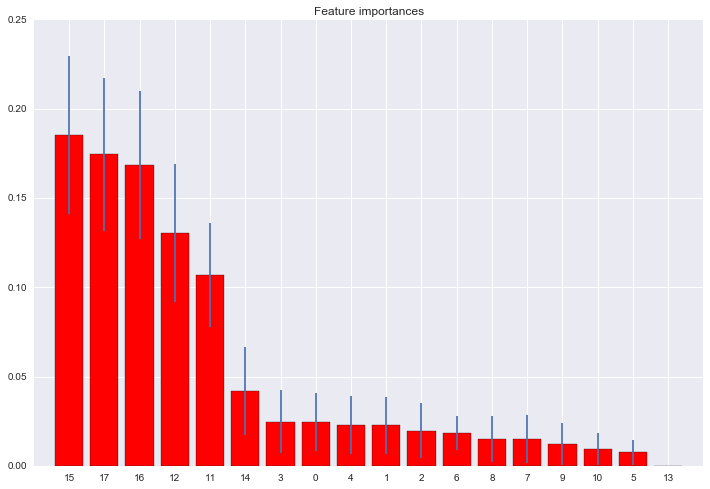

In [261]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# # Build a classification task using 3 informative features
# X_train, Y_train = make_classification(n_samples=1000,
#                            n_features=10,
#                            n_informative=3,
#                            n_redundant=0,
#                            n_repeated=0,
#                            n_classes=2,
#                            random_state=0,
#                            shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100,
                              random_state=0)

forest.fit(X_train, Y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature: %s %d (%f)" % (f + 1, all_param[f], indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [108]:
available= pd.merge(responses[responses["availability"]!=-1], inside_airbnb, how='inner',left_on=['id'], right_on=['id'])

In [109]:
sample_count = available.groupby("bucket_name")["id"].count()
print len(available)
print sample_count

104
bucket_name
days1_weeks1    10
days1_weeksM     9
days2_weeks1     9
days2_weeks2    12
days2_weeksM    10
days3_weeks1    11
days3_weeks2     5
days3_weeksM     9
daysM_weeks1    10
daysM_weeks2     9
daysM_weeksM    10
Name: id, dtype: int64


In [110]:
cal_param = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2", "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
all_param = cal_param + ["discount_asked", "nightly_price", "shared", "instant"]

In [111]:
X_train = available[all_param].values
Y_train = available["availability"].values

## Logistic Regression

In [112]:
logistic = LogisticRegression()
logistic.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

lr_scores = -cross_val_score(logistic, X_train, Y_train, scoring='mean_squared_error', cv=5)

#### Coefficient

In [113]:
zip(all_param, np.ravel(logistic.coef_))

[('orp_1', -0.67978310106545903),
 ('orp_2', 0.44899177569948689),
 ('orp_3', 0.48967858479423343),
 ('adv_1', -0.50649697324094611),
 ('adv_2', -0.45148027073001312),
 ('orp_1, adv_1', 0.2947336720609543),
 ('orp_1, adv_2', 0.0),
 ('orp_2, adv_1', -0.069988895069940132),
 ('orp_2, adv_2', 0.43221886011959287),
 ('orp_3, adv_1', -0.04378944953693914),
 ('orp_3, adv_2', 0.41504606143040967),
 ('discount_asked', -0.24696961430142622),
 ('nightly_price', 0.0044412580210620861),
 ('shared', 0.036177417352815128),
 ('instant', 0.0)]

#### Accuracy

In [114]:
logistic.score(X_train, Y_train)

0.69230769230769229

In [115]:
lr_scores

array([ 0.36363636,  0.72727273,  0.55      ,  0.4       ,  0.3       ])

#### Prediction

In [116]:
logistic.predict_proba(X_train)[:5]

array([[ 0.82316984,  0.17683016],
       [ 0.84021617,  0.15978383],
       [ 0.83849245,  0.16150755],
       [ 0.84180909,  0.15819091],
       [ 0.830444  ,  0.169556  ]])

## Random Forest

In [146]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)
# precisions=cross_validation.cross_val_score(lr, X, y, cv=kf_total, scoring='precision')

rf_scores = -cross_val_score(rf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [147]:
rf.score(X_train, Y_train)

0.84335812827753132

In [148]:
rf_scores

array([ 0.16735238,  0.23689048,  0.24374762,  0.26832857,  0.28012   ])

In [149]:
rf.predict(X_train)

array([ 0.07,  0.02,  0.  ,  0.16,  0.  ,  0.1 ,  0.74,  0.17,  0.75,
        0.06,  0.02,  0.69,  0.18,  0.05,  0.19,  0.13,  0.15,  0.17,
        0.08,  0.18,  0.04,  0.04,  0.07,  0.01,  0.68,  0.93,  0.11,
        0.93,  0.69,  0.12,  0.26,  0.68,  0.13,  0.31,  0.75,  0.19,
        0.94,  0.85,  0.76,  0.19,  0.13,  0.76,  0.97,  0.85,  0.21,
        0.05,  0.92,  0.92,  0.09,  0.04,  0.28,  0.03,  0.81,  0.08,
        0.05,  0.77,  0.75,  0.3 ,  0.67,  0.03,  0.08,  0.72,  0.8 ,
        0.83,  0.21,  0.19,  0.79,  0.09,  0.69,  0.21,  0.13,  0.26,
        0.74,  0.83,  0.66,  0.65,  0.09,  0.04,  0.09,  0.15,  0.04,
        0.35,  0.24,  0.03,  0.7 ,  0.16,  0.09,  0.68,  0.02,  0.08,
        0.1 ,  0.13,  0.13,  0.13,  0.24,  0.75,  0.68,  0.2 ,  0.06,
        0.74,  0.21,  0.71,  0.73,  0.09])

## SVM

In [134]:
clf = svm.SVC()
clf.fit(X_train, Y_train)  

clf_scores = -cross_val_score(clf, X_train, Y_train, scoring='mean_squared_error', cv=5)

In [135]:
clf.score(X_train, Y_train)

0.82692307692307687

In [136]:
clf_scores

array([ 0.45454545,  0.36363636,  0.4       ,  0.25      ,  0.35      ])

In [137]:
clf.support_vectors_

array([[   1.,    0.,    0., ...,   65.,    1.,    0.],
       [   1.,    0.,    0., ...,   32.,    1.,    0.],
       [   1.,    0.,    0., ...,   48.,    1.,    0.],
       ..., 
       [   0.,    0.,    0., ...,  283.,    0.,    0.],
       [   0.,    0.,    0., ...,   69.,    1.,    0.],
       [   0.,    0.,    0., ...,   72.,    1.,    0.]])